In [1]:
%matplotlib inline
import numpy as np
import random
import networkx as nx
import matplotlib.pylab as plt

# Random Walk prectice

[[0 1 0 0]
 [1 0 3 1]
 [0 3 0 2]
 [0 1 2 0]]


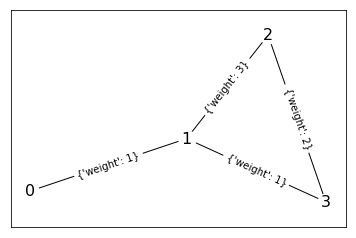

In [21]:
adj_mat=np.array([[0,1,0,0],
                  [1,0,3,1],
                  [0,3,0,2],
                  [0,1,2,0]])

print(adj_mat)

G = nx.Graph(adj_mat)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_color="w")
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_edge_labels(G, pos)
nx.draw_networkx_labels(G, pos ,font_size=16, font_color="black")

plt.xticks([])
plt.yticks([])
plt.show()

In [28]:
#normalize matrix with L2 norm

norms = np.apply_along_axis(np.linalg.norm, 0, adj_mat)
print(norms)
print( norms.reshape(-1,1))
adj_mat_norm = adj_mat / norms.reshape(-1,1)
adj_mat_norm

[ 1.          3.31662479  3.60555128  2.23606798]
[[ 1.        ]
 [ 3.31662479]
 [ 3.60555128]
 [ 2.23606798]]


array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.30151134,  0.        ,  0.90453403,  0.30151134],
       [ 0.        ,  0.83205029,  0.        ,  0.5547002 ],
       [ 0.        ,  0.4472136 ,  0.89442719,  0.        ]])

In [31]:
#normalize matrix with L1 norm
#this is transition matrix of random walk

sums = np.sum(adj_mat,axis=1).astype(np.float32)
print(sums)
adj_mat_trans = adj_mat / sums.reshape(-1,1)
adj_mat_trans

[ 1.  5.  5.  3.]


array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.2       ,  0.        ,  0.6       ,  0.2       ],
       [ 0.        ,  0.6       ,  0.        ,  0.4       ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ]])

In [6]:
#generarte pure random walk

random_walk=[np.random.choice([0,1,2,3])]
random_walk_length=10
for i in range(random_walk_length-1):
    cur_node = random_walk[-1]
    next_node=np.random.choice([0,1,2,3], 1, p=adj_mat_trans[int(cur_node)])
    random_walk.append(next_node[0])

random_walk

[3, 1, 0, 1, 2, 1, 2, 3, 2, 3]

In [7]:
#generate random walk with restart

random_walk=[np.random.choice([0,1,2,3])]
random_walk_length=10
restart_prob=0.2
start=random_walk[-1]
for i in range(random_walk_length-1):
    cur_node = random_walk[-1]
    if np.random.choice([True,False], 1, p=[0.2,0.8])[0]:
        next_node=start
    else:
        next_node=np.random.choice([0,1,2,3], 1, p=adj_mat_trans[int(cur_node)])
    random_walk.append(int(next_node))
    
random_walk

[0, 1, 2, 1, 0, 1, 2, 0, 1, 0]

# node2vec walk

node2vec has a parameterlized strategy to generate random walk. (See section 3.2.2 in the node2vec paper)  

Suppose the edge t -> v. i.e random walk jsut traversed from node t to node v  
Unnormalized transition probabilities $ \pi_{vx} = \alpha_{pq}(t,x)w_{vx} $ where   
$
  \alpha_{pq}(t,x) = \left\{ \begin{array}{ll}
    1/p & if \  d_{t,x}=0 \\
    1 & if \  d_{t,x}=1 \\
    1/q & if \ d_{t,x}=2 \\
  \end{array} \right.
$
  
Note that transition probability for a random walker at a node v now depends on the previous node t in addition to v's connections
    
Now, let's think about exmaple as follows

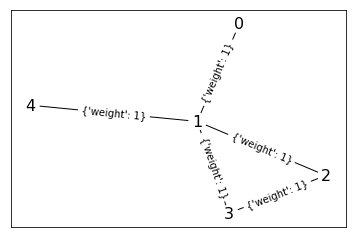

In [8]:
adj_mat=np.array([[0,1,0,0,0],
                  [1,0,1,1,1],
                  [0,1,0,1,0],
                  [0,1,1,0,0],
                  [0,1,0,0,0]])

G = nx.Graph(adj_mat)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_color="w")
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_edge_labels(G, pos)
nx.draw_networkx_labels(G, pos ,font_size=16, font_color="black")

plt.xticks([])
plt.yticks([])
plt.show()

This examples corresponds the condition that v=1, t=2, x1=3, x2=0, x3=4

let's think about the edge 2 -> 1. i.e random walk jsut traversed from node 2 to node 1.  
Then, unnormalized transition probabilities $ \pi_{1x} = \alpha_{pq}(2,x)w_{1x} $ where   
$
  \alpha_{pq}(2,x) = \left\{ \begin{array}{ll}
    1/p & if \ x=2 \ \ (i.e \ \ d_{2,x}=0) \\
    1 & if \ x=3 \ \ (i.e \ \ d_{2,x}=1) \\
    1/q & if \ x=0 \ or \ 4 \ \ (i.e \ \ d_{2,x}=2) \\
  \end{array} \right.
$
<br><br>
This can be implemented as follows

In [10]:
def alpha(p,q,t,x):
    if t==x:
        return 1.0/p
    elif adj_mat[t,x]>0:
        return 1.0
    else:
        return 1.0/q

#Test
   
v=1
t=2
p=2
q=0.5    

print(alpha(p,q,t,2))
print(alpha(p,q,t,3))
print(alpha(p,q,t,0))
print(alpha(p,q,t,4))

0.5
1.0
2.0
2.0


In [11]:
#Let's make pi for each edge using the function alpha
#The pi is stored in the follwing python dictionary whose index is edge
transition={}
#e.g. transition = {(1,2):[0.1,0,0.5,0,0.4], (1,3):[0.1,0,0.7,0,0.2], ...}
# if we want to get a transition prob from a random walker at 1 from 2, the prob is transition[1,2]

p=2
q=0.5

for t in range(adj_mat.shape[0]):
    for v in range(adj_mat.shape[1]):
        #if edge t to v exists
        if adj_mat[t,v]>0:
            num_nodes=adj_mat.shape[0]
            pi=np.zeros(num_nodes)
            for x in range(num_nodes):
                #if edge v to x exists. i.e  possible next ndoes from v
                if adj_mat[v,x]>0:
                    pi[x]=alpha(p,q,t,x)*adj_mat[v,x]
                    #pi[x] is nunormlized transion probability from v to x where v is traversed from t
            pi=pi/np.sum(pi)
            #now, pi is normalzied transion probabilities for v traversed from t
            transition[t,v]=pi

In [13]:
#Now we have pre-computed random walk transition probabilities (i.e python dict transition)
#So let's use this to generate random walk for a given node

#get random walk 
all_nodes=[0,1,2,3,4]
random_edge_index=np.random.choice(len(transition))
random_edge=list(transition.keys())[random_edge_index]
random_walk=[random_edge[0],random_edge[1]]
random_walk_length=10
for i in range(random_walk_length-2):
    cur_node = random_walk[-1]
    precious_node=random_walk[-2]
    next_node=np.random.choice(all_nodes, 1, p=transition[precious_node,cur_node])
    random_walk.append(next_node[0])
    
random_walk

[0, 1, 2, 3, 1, 3, 1, 0, 1, 4]

In [14]:
#let's use sparse vector to store transition probabilities

transition_sparse={}

#Let's make pi for each edge using the function alpha
#The pi is stored in the follwing python dictionary whose index is edge

p=2
q=0.5

for t in range(adj_mat.shape[0]):
    for v in range(adj_mat.shape[1]):
        #if edge t to v exists
        if adj_mat[t,v]>0:
            pi_vx_indices=[]
            pi_vx_values =[]
            for x in range(num_nodes):
                #if edge v to x exists. i.e  possible next ndoes from v
                if adj_mat[v,x]>0:
                    pi_vx_indices.append(x)
                    pi_vx_values.append(alpha(p,q,t,x)*adj_mat[v,x])
                    #pi[x] is nunormlized transion probability from v to x where v is traversed from t
            pi_vx_values=np.array(pi_vx_values)/sum(pi_vx_values)
            #now, pi is normalzied transion probabilities for v traversed from t
            transition_sparse[t,v]=(pi_vx_indices,pi_vx_values)

In [16]:
# see they are the same
print(transition[0,1])
print(transition_sparse[0,1])

[ 0.07692308  0.          0.30769231  0.30769231  0.30769231]
([0, 2, 3, 4], array([ 0.07692308,  0.30769231,  0.30769231,  0.30769231]))


In [18]:
#get random walk 
all_nodes=[0,1,2,3,4]
random_edge_index=np.random.choice(len(transition))
random_edge=list(transition.keys())[random_edge_index]
random_walk=[random_edge[0],random_edge[1]]
random_walk_length=10
for i in range(random_walk_length-2):
    cur_node = random_walk[-1]
    precious_node=random_walk[-2]
    (pi_vx_indices,pi_vx_values)=transition_sparse[precious_node,cur_node]
    next_node=np.random.choice(pi_vx_indices, 1, p=pi_vx_values)
    random_walk.append(next_node[0])
    
random_walk

[0, 1, 3, 2, 3, 2, 1, 0, 1, 2]

In [371]:
#next steps
#implement a case that the adjacent matrix is sparse matrix
#implement a muti prosessing code to generate random walks